In [208]:
import numpy as np
import matplotlib.pyplot as plt

In [209]:
namesngenre = np.load('./dataset/namesngenre.npy')

In [210]:
namesngenre

array([['Toy Story (1995)',
        'Adventure|Animation|Children|Comedy|Fantasy'],
       ['Jumanji (1995)', 'Adventure|Children|Fantasy'],
       ['Grumpier Old Men (1995)', 'Comedy|Romance'],
       ...,
       ['Elsa & Fred (2005)', 'Comedy|Drama|Romance'],
       ['Tomb Raider (2018)', 'Action|Adventure|Fantasy'],
       ['Fred Armisen: Standup for Drummers (2018)', 'Comedy']],
      dtype='<U158')

In [211]:
ratings_train = np.load('./dataset/ratings_train.npy')

In [212]:
ratings_train.shape

(610, 4980)

In [213]:
ratings_train

array([[ 4., nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan,  2., nan, ..., nan, nan, nan],
       [ 3., nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

In [214]:
np.nanmax(ratings_train)

5.0

In [260]:
import MF
import importlib

# Reload a specific module
importlib.reload(MF)

<module 'MF' from 'c:\\Users\\User\\Documents\\Estudos\\M2 Dauphine\\Data Science Lab\\collaborativer_filter_user_recommendation\\collaborative_filter\\MF.py'>

In [261]:
k = 10

MF = MF.MatrixFactorizarion(ratings_train, l=0.01, mu=0.01, k=k)


[[3.52460599 3.52460599 3.52460599 ... 3.52460599 3.52460599 3.52460599]
 [3.52460599 3.52460599 3.52460599 ... 3.52460599 3.52460599 3.52460599]
 [3.52460599 3.52460599 3.52460599 ... 3.52460599 3.52460599 3.52460599]
 ...
 [3.52460599 3.52460599 3.52460599 ... 3.52460599 3.52460599 3.52460599]
 [3.52460599 3.52460599 3.52460599 ... 3.52460599 3.52460599 3.52460599]
 [3.52460599 3.52460599 3.52460599 ... 3.52460599 3.52460599 3.52460599]]


In [262]:
print(MF.C(MF.R, MF.I, MF.U, l=0.000001, mu=0.00001))

37379477.749730475


In [263]:
non_nan_indices = np.where(~np.isnan(ratings_train))
# Separate the row and column indices
row_indices, col_indices = non_nan_indices
R_non_nan = MF.R[row_indices, col_indices]

In [264]:
MF.fit(lr_I=0.0001, lr_U=0.0001, num_iterations=20)
prediction_full = MF.predict()
prediction = prediction_full[row_indices, col_indices]
MF.RMSE(prediction, R_non_nan)

Iteration 1: Cost = 37369584.06732292. RMSE = 1.0092575577996472
Iteration 2: Cost = 37378049.30043625. RMSE = 0.9932995275995585
Iteration 3: Cost = 37397149.686369576. RMSE = 0.9812191962593021
Iteration 4: Cost = 37422509.40713892. RMSE = 0.9714745665341679
Iteration 5: Cost = 37451478.25630709. RMSE = 0.9632987712866515
Iteration 6: Cost = 37482372.747985825. RMSE = 0.9562605294806762
Iteration 7: Cost = 37514088.13533993. RMSE = 0.9500909590261649
Iteration 8: Cost = 37545884.464933254. RMSE = 0.944608964935709
Iteration 9: Cost = 37577261.06214197. RMSE = 0.9396856298074797
Iteration 10: Cost = 37607879.13575013. RMSE = 0.9352254023642923
Iteration 11: Cost = 37637512.09305803. RMSE = 0.9311552510397813
Iteration 12: Cost = 37666012.56792692. RMSE = 0.9274179696829028
Iteration 13: Cost = 37693289.920861654. RMSE = 0.9239678316184105
Iteration 14: Cost = 37719294.516333856. RMSE = 0.9207676588566104
Iteration 15: Cost = 37744006.511634775. RMSE = 0.9177867851335187
Iteration 16: 

0.9054004042464256

In [265]:
prediction_full = MF.predict()

## Result analysis

__Attention:__ Here we pick only the non nan values, which returns a 1-D array. Then we reshape a part of them so we can see it as a image and visually comapre the results.

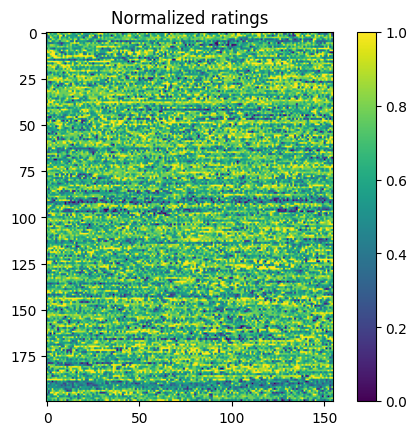

In [266]:
non_nan_indices = np.where(~np.isnan(ratings_train))
# Separate the row and column indices
row_indices, col_indices = non_nan_indices
R_non_nan = MF.R[row_indices, col_indices]
normalized_ratings = (R_non_nan - np.min(R_non_nan)) / (np.max(R_non_nan) - np.min(R_non_nan))
normalized_ratings = normalized_ratings[:normalized_ratings.shape[0]//1000 * 1000].reshape(200, -1)

# Create a heatmap using a colormap (e.g., 'viridis')
plt.imshow(normalized_ratings, cmap='viridis')
plt.colorbar()  # Add a colorbar for reference

# Show the heatmap
plt.title('Normalized ratings')
plt.show()


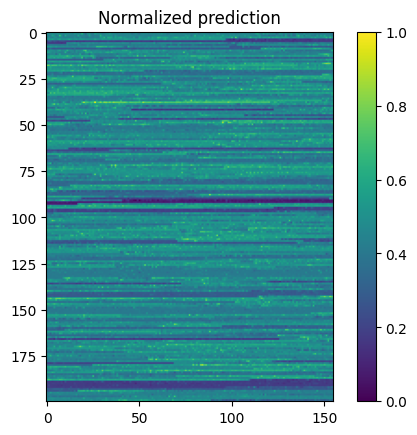

In [267]:
# Separate the row and column indices
row_indices, col_indices = non_nan_indices

# Access the corresponding values in the second matrix
prediction = prediction_full[row_indices, col_indices]
normalized_prediction = (prediction - np.min(prediction)) / (np.max(prediction) - np.min(prediction))
normalized_prediction = normalized_prediction[:normalized_prediction.shape[0]//1000 * 1000].reshape(200, -1)
# Create a heatmap using a colormap (e.g., 'viridis')
plt.imshow(normalized_prediction, cmap='viridis')
plt.colorbar()  # Add a colorbar for reference

# Show the heatmap
plt.title('Normalized prediction')
plt.show()

In [268]:

MF.RMSE(prediction, R_non_nan)

0.9054004042464256